## r5py的交通可达性: 文件准备 | 准备网格+目标点数据 | 中心点与计算旅行时间 | 计算可达性 | 可视化

### park accessibility

#### 格子

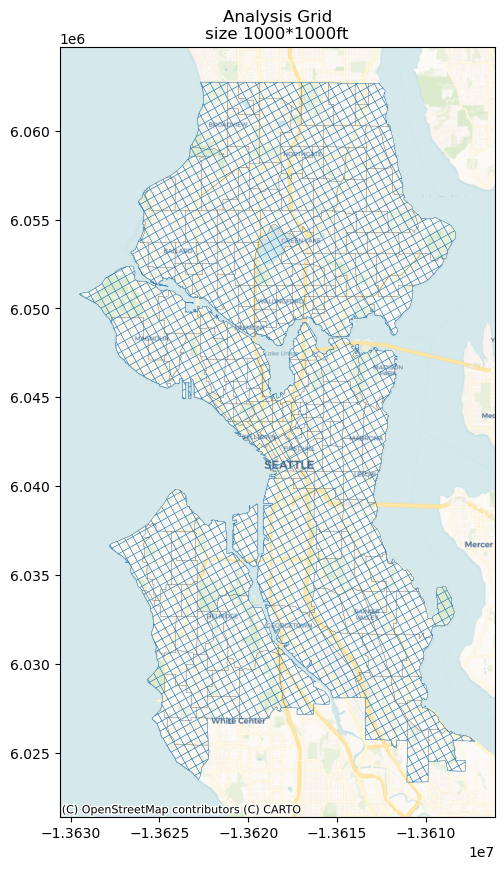

In [1]:
# Required Libraries
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
from contextily import add_basemap
import contextily as cx

# 加载seattle boundary
seattle_boundary = gpd.read_file("Seattle_City_Boundary.geojson")
seattle_boundary = seattle_boundary.to_crs(epsg=2272)  # Transform to a projection in feet

# 设置grid大小
grid_size = 1000  # 1000 feet

# 在seattle boundary 绘制 grids
minx, miny, maxx, maxy = seattle_boundary.total_bounds
x_range = maxx - minx
y_range = maxy - miny

# 绘制grids
rows = int(y_range / grid_size)
cols = int(x_range / grid_size)
grid = []
for i in range(cols + 1):
    for j in range(rows + 1):
        grid.append(box(minx + i * grid_size, miny + j * grid_size, minx + (i + 1) * grid_size, miny + (j + 1) * grid_size))


# 选择适合的投影坐标系统
projected_crs = '3857'  # Web Mercator 投影
# 确保 CRS 转换

grid_gdf = gpd.GeoDataFrame(geometry=grid, crs=seattle_boundary.crs)
grid_gdf = gpd.clip(grid_gdf, seattle_boundary)
grid_gdf = grid_gdf.to_crs(epsg=projected_crs)
seattle_boundary = seattle_boundary.to_crs(epsg=projected_crs)

# 计算几何中心
centroids = grid_gdf.centroid

# Plot the grid
fig, ax = plt.subplots(figsize=(10, 10))

seattle_boundary.plot(ax=ax, color='none', edgecolor='black',linewidth=0.1)
grid_gdf.plot(ax=ax, facecolor='none', edgecolor='#3182bd', linewidth=0.3)
# Add basemap
cx.add_basemap(ax, crs=grid_gdf.crs.to_string(), source=cx.providers.CartoDB.Voyager, zoom=12)

plt.title("Analysis Grid\nsize 1000*1000ft")
plt.show()

In [3]:
centroids

2852    POINT (-13607929.576 6024182.438)
2853    POINT (-13608073.372 6024456.949)
2945     POINT (-13607794.62 6024535.642)
2854    POINT (-13608434.294 6024924.274)
3038    POINT (-13607437.757 6025659.083)
                      ...                
4503     POINT (-13620017.517 6062062.84)
4688     POINT (-13619473.878 6062687.24)
4504     POINT (-13620234.83 6062455.588)
4596    POINT (-13619836.782 6062600.019)
4505    POINT (-13620458.835 6062673.503)
Length: 2677, dtype: geometry

In [5]:
grid_gdf.head()

,geometry
2852,"POLYGON ((-13608159.542 6024257.989, -13607787..."
2853,"POLYGON ((-13607787.488 6024509.448, -13607787..."
2945,"POLYGON ((-13607809.247 6024549.043, -13607787..."
2854,"POLYGON ((-13608375.281 6024650.517, -13608591..."
3038,"POLYGON ((-13607416.937 6025692.292, -13607389..."


In [6]:
grid_gdf['centroid'] = grid_gdf.index.map(centroids)

In [7]:
grid_gdf.head()

,geometry,centroid
2852,"POLYGON ((-13608159.542 6024257.989, -13607787...",POINT (-13607929.576 6024182.438)
2853,"POLYGON ((-13607787.488 6024509.448, -13607787...",POINT (-13608073.372 6024456.949)
2945,"POLYGON ((-13607809.247 6024549.043, -13607787...",POINT (-13607794.62 6024535.642)
2854,"POLYGON ((-13608375.281 6024650.517, -13608591...",POINT (-13608434.294 6024924.274)
3038,"POLYGON ((-13607416.937 6025692.292, -13607389...",POINT (-13607437.757 6025659.083)


#### 数据处理

In [8]:
import geopandas as gpd

In [9]:
import pandas as pd

In [10]:
import numpy as np

In [11]:
import matplotlib.pyplot as plt

In [12]:
from shapely.geometry import Point

In [13]:
from sklearn.neighbors import NearestNeighbors

In [14]:
import contextily as cx

In [15]:
from libpysal.weights import KNN

In [16]:
from pysal.model.spreg import ML_Lag

In [17]:
parks = gpd.read_file('SeattleParkPoints.geojson')

# 投影转换
parks_proj = parks.to_crs(epsg=projected_crs)  
parks_proj.head()

,OBJECTID,PROPNAME,ADDRESS,DIVISION,ADA,GIS_EDT_DT,LATITUDE,LONGITUDE,POINT_X,POINT_Y,...,LOCID,AMWO_ID,RES1,RES2,GLOBALID,GIS_CREATOR,GIS_CRT_DT,GIS_EDITOR,SDQL,geometry
0,7044,Alki Playground,5817 SW Lander St,South,Yes,"Mon, 29 Jul 2024 19:16:43 GMT",47.577899,-122.407731,1.251850e+06,214775.000001,...,1049,PLAY-ALKIPG,None,None,17ca3d9c-c23f-41f4-927f-5f4583822a15,SeattleParks_SeattleCityGIS,"Mon, 29 Jul 2024 19:16:43 GMT",SeattleParks_SeattleCityGIS,QL-D3,POINT (-13626367.925 6036918.326)
1,7045,B.F. Day Playground,4020 Fremont Ave N,North,Yes,"Mon, 29 Jul 2024 19:16:43 GMT",47.655668,-122.348906,1.266925e+06,242845.296892,...,2552,PLAY-DAYPG,None,None,2b87dea1-038d-4a59-98f0-db9ad09725ff,SeattleParks_SeattleCityGIS,"Mon, 29 Jul 2024 19:16:43 GMT",SeattleParks_SeattleCityGIS,QL-D3,POINT (-13619819.517 6049761.138)
2,7046,Ballard Playground,2644 NW 60th St,North,Yes,"Mon, 29 Jul 2024 19:16:43 GMT",47.672648,-122.392548,1.256297e+06,249252.812470,...,1108,PLAY-BLPG,None,None,ff837c9b-46fd-4b79-8eda-d51a40268425,SeattleParks_SeattleCityGIS,"Mon, 29 Jul 2024 19:16:43 GMT",SeattleParks_SeattleCityGIS,QL-D3,POINT (-13624677.828 6052567.874)
3,7047,Bayview Playground,2614 24th Ave W,Central,Yes,"Mon, 29 Jul 2024 19:16:43 GMT",47.644301,-122.386906,1.257478e+06,238886.812472,...,1110,PLAY-BVPG,None,None,c7a03c40-dbb7-4dcf-ac40-bb26e9c9b3b2,SeattleParks_SeattleCityGIS,"Mon, 29 Jul 2024 19:16:43 GMT",SeattleParks_SeattleCityGIS,QL-D3,POINT (-13624049.657 6047882.884)
4,7048,Bayview-Kinnear Park,3rd Ave W / W Prospect St,Central,Yes,"Mon, 29 Jul 2024 19:16:43 GMT",47.628900,-122.360237,1.263939e+06,233138.296906,...,2374,PLAY-KERPK,None,None,10ab7d68-dd5c-43cc-98a4-b85c233bdc56,SeattleParks_SeattleCityGIS,"Mon, 29 Jul 2024 19:16:43 GMT",SeattleParks_SeattleCityGIS,QL-D3,POINT (-13621080.948 6045338.439)


In [18]:
# 进行空间连接，将公园数据分配到栅格单元格
park_joined_gdf = gpd.sjoin(parks_proj,grid_gdf,how="left", predicate="intersects")
# 计算每个栅格单元格中的公园数量
# 在使用 geopandas 进行空间连接（sjoin）时，index_right 是 geopandas.sjoin 函数默认生成的列之一，用于表示与连接结果中的目标 GeoDataFrame 的索引相关联的行。
park_counts = park_joined_gdf.groupby('index_right').size()  # 'index_right' 是指栅格单元格的索引
# 将结果赋值回原始的 grid_gdf
grid_gdf['park_count'] = grid_gdf.index.map(park_counts).fillna(0).astype(int)

In [19]:
from pyproj import Transformer
import geopandas as gpd
from shapely.geometry import Point

# 转换函数
def transform_point(_transformer,point):
    lon, lat = _transformer.transform(point.x, point.y)
    return Point(lon, lat)


In [21]:
import r5py

In [22]:
import geopandas

In [23]:
import datetime
# import datetime 语句用于导入 Python 的 datetime 模块，该模块是一个强大的日期和时间处理库，提供了多个类来处理日期和时间，
# 主要包括 datetime.date、datetime.time、datetime.datetime、datetime.timedelta、datetime.timezone 等类2。

In [24]:
import time 
#在编程中，import time 语句用于导入 Python 的 time 模块。该模块提供了各种与时间相关的函数和类，可用于获取当前时间、测量代码执行时间、暂停程序执行等操作。

In [25]:
from tqdm import tqdm
# tqdm 是一个快速、可扩展的 Python 进度条库，可用于在循环中显示进度条，跟踪循环的执行进度。

In [26]:
### 1.指定 OpenStreetMap 数据文件的路径 + 加载 OSM 数据并创建交通网络对象。

# 获取当前时间
start_time = time.time()
# 可以使用 time.time() 函数获取当前的时间戳，它返回自 1970 年 1 月 1 日午夜（UTC）以来的秒数。

# 读取pdb文件
osm_pbf_path = 'seattle.osm.pbf'

# 创建TransportNetwork对象
transport_network = r5py.TransportNetwork(osm_pbf_path)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"创建运行时间: {elapsed_time} 秒")


### 2.准备网格和目标点数据（并获取中心点）

# 假设网格和公园数据都有一个唯一标识符的列，分别重命名为 'id'
grid_gdf_4timematrix = grid_gdf.rename(columns={"centroid": "id"}) # 替换为网格数据中的唯一标识符列名
parks_4timematrix = parks_proj.rename(columns={'OBJECTID': 'id'})  # 替换为公园数据中的唯一标识符列名

# 获取网格单元的中心点作为起点和终点
origins = grid_gdf_4timematrix.copy()
origins['geometry'] = origins.geometry.centroid

destinations = parks_4timematrix.copy()
destinations['geometry'] = destinations.geometry.centroid

# 定义批次大小
batch_size_origins = 100  # 可以根据实际情况调整
# 定义了起点数据的批次大小为 100。这意味着在后续处理起点数据时，会将起点数据按每 100 个元素划分为一个批次。该值可以根据实际的计算资源、数据特点等因素进行调整。
batch_size_destinations = 10  # 可以根据实际情况调整
# 定义了终点数据的批次大小为 10。同理，在处理终点数据时，会将终点数据按每 10 个元素划分为一个批次，也可根据实际情况灵活调整。

# 将起点和终点分成批次
origins_batches = np.array_split(origins, len(origins) // batch_size_origins + 1) # split(起始点数组,需要划分的数组数量)
destinations_batches = np.array_split(destinations, len(destinations) // batch_size_destinations + 1)

# np.array_split 是 NumPy 库中的一个函数，用于将一个数组分割成多个子数组。
# origins 是存储起点数据的数组。
# len(origins) // batch_size_origins + 1 计算了需要将起点数据划分成的批次数量。
# len(origins) // batch_size_origins 是整除操作，得到的是完整批次的数量，
# 加 1 是为了确保即使最后一个批次的数据不足 batch_size_origins 个，也会单独作为一个批次。
# 最终，origins_batches 是一个包含多个子数组的数组，每个子数组代表一个起点数据的批次。

all_travel_times = []
end_time = time.time()
elapsed_time = end_time - start_time
print(f"开始计算运行时间: {elapsed_time} 秒")


### 3.计算旅行时间

# 逐批次计算旅行时间
for origins_batch in tqdm(origins_batches):
    for destinations_batch in tqdm(destinations_batches):
        travel_time_matrix = r5py.TravelTimeMatrixComputer(
            transport_network,
            origins=origins_batch,
            destinations=destinations_batch,
            transport_modes=[r5py.TransportMode.BICYCLE],
            departure=datetime.datetime(2025, 10, 5, 9, 0, 0),
        ).compute_travel_times()
        all_travel_times.append(travel_time_matrix)

# 合并所有批次的结果
final_travel_time_matrix = pd.concat(all_travel_times, ignore_index=True)

# 保存为 CSV 文件
final_travel_time_matrix.to_csv('travel_time_matrix.csv', index=False)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"计算运行时间: {elapsed_time} 秒")


/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/anaconda3/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/opt/anaconda3/lib/pytho

创建运行时间: 1.6315112113952637 秒
开始计算运行时间: 1.6720619201660156 秒


  0%|                                                    | 0/27 [00:00<?, ?it/s]
/var/folders/hx/vrwsgqgx7bncbt28n44f0b540000gn/T/ipykernel_18324/4012605687.py:59: DeprecationWarning: Use `TravelTimeMatrix` instead, `TravelTimeMatrixComputer will be deprecated in a future release.
  travel_time_matrix = r5py.TravelTimeMatrixComputer(

/var/folders/hx/vrwsgqgx7bncbt28n44f0b540000gn/T/ipykernel_18324/4012605687.py:59: DeprecationWarning: Use `TravelTimeMatrix` instead, `TravelTimeMatrixComputer will be deprecated in a future release.
  travel_time_matrix = r5py.TravelTimeMatrixComputer(

/var/folders/hx/vrwsgqgx7bncbt28n44f0b540000gn/T/ipykernel_18324/4012605687.py:59: DeprecationWarning: Use `TravelTimeMatrix` instead, `TravelTimeMatrixComputer will be deprecated in a future release.
  travel_time_matrix = r5py.TravelTimeMatrixComputer(

/var/folders/hx/vrwsgqgx7bncbt28n44f0b540000gn/T/ipykernel_18324/4012605687.py:59: DeprecationWarning: Use `TravelTimeMatrix` instead, `TravelTimeMatri

计算运行时间: 35243.76646924019 秒


In [ ]:
# 下次加载时间最好用 travel_time_matrix = r5py.TravelTimeMatrix(
#             transport_network,
#             origins=origins_batch,
#             destinations=destinations_batch,
#             transport_modes=[r5py.TransportMode.BICYCLE],
#             departure=datetime.datetime(2024, 8, 3, 9, 0, 0),
#         ).compute_travel_times()


In [28]:
### 4.计算并可视化可达性

import pandas as pd
file_path = 'travel_time_matrix.csv'
travel_time_matrix = pd.read_csv(file_path)

# 设置10分钟的时间阈值
time_threshold = 10   # 10分钟

# 统计每个网格单元（from_id）在时间范围内可以到达的唯一公园数量
travel_time_matrix= travel_time_matrix[travel_time_matrix["travel_time"] <= time_threshold]# 使用给定时间阈值

accessible_parks_count = (
    travel_time_matrix .groupby("from_id")  # 按照from_id分组
    .agg({'to_id': 'nunique'})  # 计算每个from_id对应的唯一to_id数量
)

# 将结果转换为DataFrame，并将计数值作为新列添加
accessible_parks_df = accessible_parks_count.reset_index()
accessible_parks_df.columns = ['from_id', 'accessible_parks_count']

print(accessible_parks_df)


                                            from_id  accessible_parks_count
0     POINT (-13607346.105996933 6025672.622685946)                       1
1     POINT (-13607426.487352619 6025751.542839298)                       1
2     POINT (-13607437.757096048 6025659.083210062)                       1
3     POINT (-13607728.797424044 6025785.211382896)                       1
4      POINT (-13607794.62028457 6024535.642157198)                       1
...                                             ...                     ...
2135   POINT (-13627538.85419853 6036705.883455862)                       2
2136   POINT (-13627578.57007992 6049120.503464477)                       1
2137  POINT (-13627611.584194597 6051680.132118877)                       1
2138  POINT (-13627668.615034916 6036469.432148479)                       2
2139  POINT (-13627756.421064945 6036590.847211846)                       2

[2140 rows x 2 columns]


In [29]:
import geopandas as gpd
from shapely import wkt
# 在shapely库中，可以从shapely.wkt模块导入dumps和loads函数，用于处理WKT（Well-Known Text）格式的几何数据。
# dumps函数用于将shapely的几何对象转换为WKT字符串，而loads函数则用于将WKT字符串转换为shapely的几何对象。

# 将 from_id 字符串转换为 Shapely Point 对象
accessible_parks_df['geometry'] = accessible_parks_df['from_id'].apply(wkt.loads)

# 将 DataFrame 转换为 GeoDataFrame
accessible_parks_gdf = gpd.GeoDataFrame(accessible_parks_df, geometry='geometry')

accessible_parks_gdf.head()

,from_id,accessible_parks_count,geometry
0,POINT (-13607346.105996933 6025672.622685946),1,POINT (-13607346.106 6025672.623)
1,POINT (-13607426.487352619 6025751.542839298),1,POINT (-13607426.487 6025751.543)
2,POINT (-13607437.757096048 6025659.083210062),1,POINT (-13607437.757 6025659.083)
3,POINT (-13607728.797424044 6025785.211382896),1,POINT (-13607728.797 6025785.211)
4,POINT (-13607794.62028457 6024535.642157198),1,POINT (-13607794.62 6024535.642)


In [30]:
accessible_parks_gdf.set_crs(grid_gdf.crs, inplace=True)  # 设置坐标参考系
accessible_parks_gdf = accessible_parks_gdf.to_crs(grid_gdf.crs)   # 转换坐标参考系

In [31]:
# 使用空间连接 (spatial join) 进行连接
joined_gdf = gpd.sjoin(grid_gdf, accessible_parks_gdf , how="left", predicate="intersects")

# 填充 NaN 值，假设有些格子在 10 分钟内没有可达的公园，可以用 0 填充
joined_gdf['accessible_parks_count'] = joined_gdf['accessible_parks_count'].fillna(0)

print(joined_gdf)

                                               geometry  \
2852  POLYGON ((-13608159.542 6024257.989, -13607787...   
2853  POLYGON ((-13607787.488 6024509.448, -13607787...   
2945  POLYGON ((-13607809.247 6024549.043, -13607787...   
2854  POLYGON ((-13608375.281 6024650.517, -13608591...   
3038  POLYGON ((-13607416.937 6025692.292, -13607389...   
...                                                 ...   
4503  POLYGON ((-13620105.278 6061757.117, -13620322...   
4688  POLYGON ((-13619537.166 6062586.261, -13619620...   
4504  POLYGON ((-13619929.75 6062368.569, -13620322....   
4596  POLYGON ((-13619537.166 6062586.261, -13619929...   
4505  POLYGON ((-13620539.372 6062544.626, -13620646...   

                               centroid  park_count  index_right  \
2852  POINT (-13607929.576 6024182.438)           0          5.0   
2853  POINT (-13608073.372 6024456.949)           0          7.0   
2945   POINT (-13607794.62 6024535.642)           0          4.0   
2854  POINT (-13608

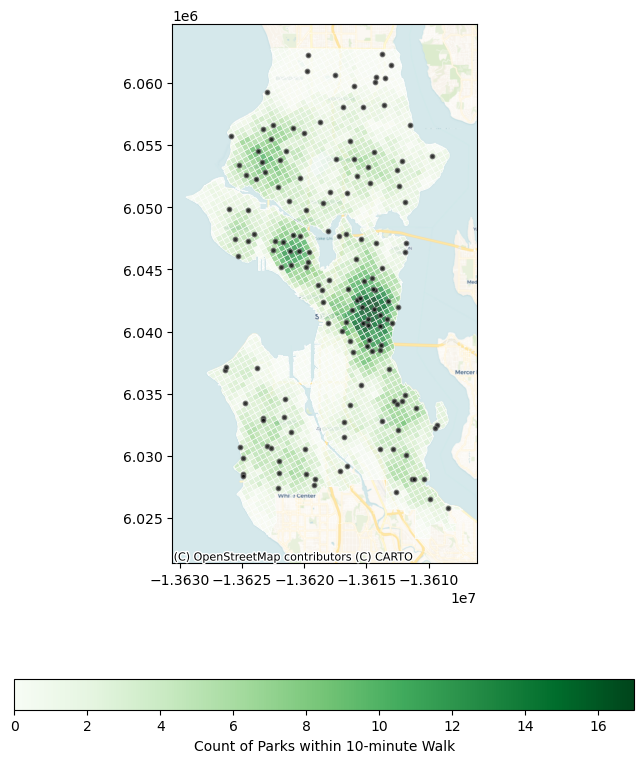

In [35]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

joined_gdf.plot(column='accessible_parks_count', cmap='Greens', linewidth=0.5, ax=ax, edgecolor='white', legend=True, 
                legend_kwds={'label': "Count of Parks within 10-minute Walk",  # 确保标签描述准确
                             'orientation': "horizontal",
                             'shrink': 0.8},
               alpha = 0.8)
parks_proj.plot(ax=ax, marker='o', color='black', edgecolor='#636363', markersize=10, alpha=0.8)
cx.add_basemap(ax, crs=grid_gdf.crs.to_string(), source=cx.providers.CartoDB.Voyager, zoom=12)